In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import spatial

In [3]:
colsname = ['x', 'y', 'z', 'xn', 'yn', 'zn', 'R', 'G', 'B', 'A', 'quality', 'zz']
lidar = pd.read_csv('../data/20180911_SHCCurb3.ply',
                    delimiter=' ',
                    skiprows=18,
                    #nrows=500000, #use None to read the complete dataset or the number of first rows to read
                    header=None,
                    #error_bad_lines=False,
                    #keep_default_na=False,
                    #dtype={0:'float', 1:'float', 2:'float', 3:'float', 4:'int', 5:'int', 6:'int'},
                    #skipfooter=20, engine='python',
                    #
                    )
lidar.columns=colsname
lidar.drop(['zz'], inplace=True, axis=1)
lidar.head()

,x,y,z,xn,yn,zn,R,G,B,A,quality
0,6.531357,-6.797287,-2.386337,0.035693,-0.037846,0.998646,121,142,104,255,0.193973
1,6.504440,-6.783005,-2.385269,0.044266,-0.033033,0.998474,87,106,78,255,0.188113
2,6.539658,-6.819748,-2.388138,0.050499,-0.032237,0.998204,130,147,110,255,0.190311
3,6.489365,-6.780930,-2.385605,0.051617,-0.021600,0.998433,92,113,81,255,0.195926
4,6.523087,-6.816177,-2.387894,0.046914,-0.039101,0.998133,114,133,97,255,0.185672


# Spatial aggregation feature

In [4]:
tree = spatial.KDTree(lidar[['x', 'y', 'z']])

In [7]:
lidar[['x', 'y', 'z']].iloc[[2501, 2502]]

,x,y,z
2501,5.860001,-7.658310,-2.376114
2502,5.894424,-7.703323,-2.379776


In [8]:
tree.query_ball_point((lidar[['x', 'y', 'z']].iloc[[2501, 2502]]), .05)

array([list([2716, 2544, 2587, 2630, 2586, 2629, 2672, 2375, 2416, 2459, 2501, 2543, 2460, 2334, 2417]),
       list([2674, 2503, 2588, 2544, 2587, 2631, 2673, 2717, 2335, 2376, 2418, 2460, 2461, 2502, 2545, 2377, 2417])],
      dtype=object)

In [27]:
from scipy import spatial

class Spatialagg():
    def __init__(self, dataset, coordinatesnames=['x', 'y', 'z'], radius=.05, p=2):
        self.tree = spatial.KDTree(dataset[coordinatesnames], p=p)
        self.dataset = dataset
        self.radius = radius
        self.coordinatesnames = coordinatesnames
    
    def agg(self, pointcoord, field, feature=np.std):
        df = self.dataset.iloc[self.getiloc(pointcoord)]
        return feature(df[field])
    
    def getiloc(self, pointcoord):
        return self.tree.query_ball_point(pointcoord[self.coordinatesnames], self.radius)

spatialagg = Spatialagg(lidar,)

In [28]:
spatialagg.agg(pointcoord=lidar.iloc[2501],
               field='xn',
               feature=np.std)

0.004276876600125948

In [29]:
spatialagg.getiloc(lidar.iloc[2501])

[2716,
 2544,
 2587,
 2630,
 2586,
 2629,
 2672,
 2375,
 2416,
 2459,
 2501,
 2543,
 2460,
 2334,
 2417]

In [39]:
lidar['tag'] = 0
lidar['tag'].iloc[spatialagg.getiloc(lidar.iloc[25000])] = 1
lidar.head()

C:\Users\student\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,x,y,z,xn,yn,zn,R,G,B,A,quality,tag
0,6.531357,-6.797287,-2.386337,0.035693,-0.037846,0.998646,121,142,104,255,0.193973,0
1,6.504440,-6.783005,-2.385269,0.044266,-0.033033,0.998474,87,106,78,255,0.188113,0
2,6.539658,-6.819748,-2.388138,0.050499,-0.032237,0.998204,130,147,110,255,0.190311,0
3,6.489365,-6.780930,-2.385605,0.051617,-0.021600,0.998433,92,113,81,255,0.195926,0
4,6.523087,-6.816177,-2.387894,0.046914,-0.039101,0.998133,114,133,97,255,0.185672,0


C:\Users\student\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


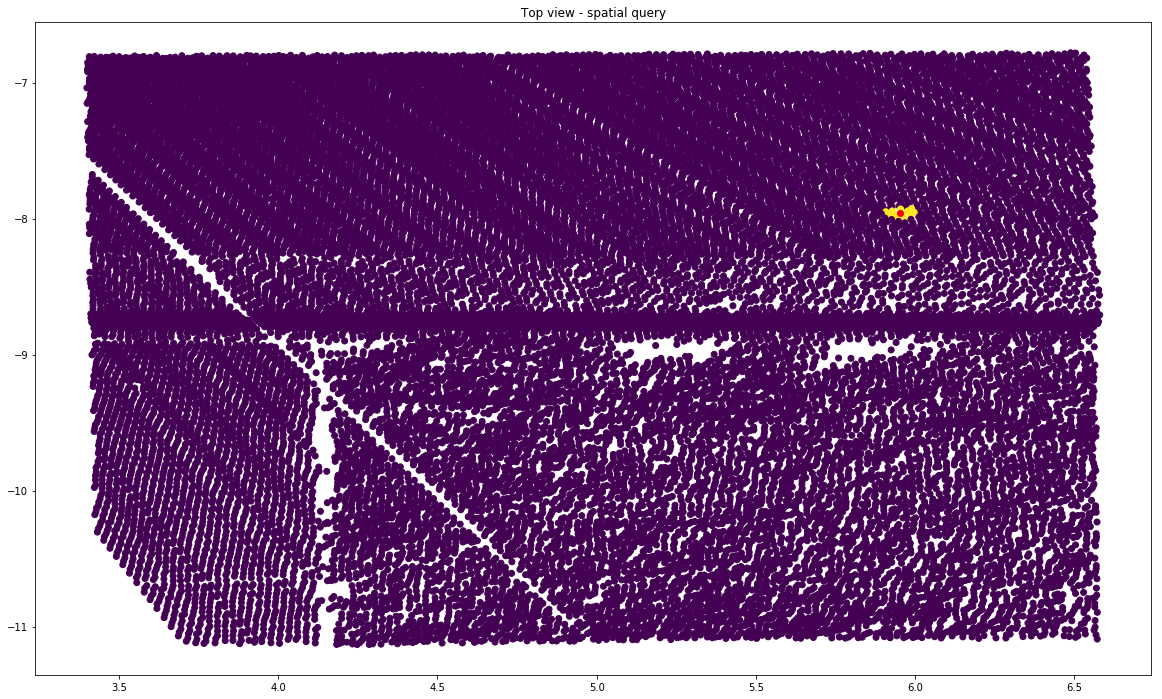

In [44]:
# Top view - Z Normal - KNN
ilocnum = 3000

lidar['tag'] = 0
lidar['tag'].iloc[spatialagg.getiloc(lidar.iloc[ilocnum])] = 1

fig = plt.figure(figsize=(20,12))
plt.scatter(x=lidar.x, y=lidar.y, c=lidar.tag)
plt.scatter(x=lidar.x.iloc[ilocnum], y=lidar.y.iloc[ilocnum], c='r')
plt.title('Top view - spatial query')
#plt.colorbar()
plt.show()

In [26]:
lidar.apply(spatialagg.agg, axis=1, args=('xn', ))

0        0.005411
1        0.009011
2        0.005665
3        0.008753
4        0.008468
5        0.008375
6        0.008280
7        0.007957
8        0.008000
9        0.007194
10       0.006562
11       0.006603
12       0.006731
13       0.004528
14       0.004854
15       0.007561
16       0.005002
17       0.003928
18       0.006945
19       0.007001
20       0.005142
21       0.003658
22       0.006210
23       0.007437
24       0.006585
25       0.003731
26       0.005864
27       0.007591
28       0.006227
29       0.004368
           ...   
29153    0.003060
29154    0.004199
29155    0.003228
29156    0.002972
29157    0.002349
29158    0.005599
29159    0.006924
29160    0.001828
29161    0.002319
29162    0.004014
29163    0.006204
29164    0.009821
29165    0.003706
29166    0.003696
29167    0.003173
29168    0.004775
29169    0.003086
29170    0.002607
29171    0.003390
29172    0.005900
29173    0.004843
29174    0.002040
29175    0.001278
29176    0.008074
29177    0

In [14]:
np.array(lidar[['x', 'y', 'z']].iloc[2501])

array([ 5.860001, -7.65831 , -2.376114])

In [5]:
lidar[['x', 'y', 'z']].iloc[0]

x    6.531357
y   -6.797287
z   -2.386337
Name: 0, dtype: float64

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
points = np.asarray(points)
plt.plot(points[:,0], points[:,1], '.')
for results in tree.query_ball_point(([2, 0], [3, 3]), 1.5):
    nearby_points = points[results]
    plt.plot(nearby_points[:,0], nearby_points[:,1], 'o')
plt.margins(0.1, 0.1)
plt.show()

https://gis.stackexchange.com/questions/295622/calculate-standard-deviation-with-nearest-neighbors  
https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.KDTree.query_ball_point.html#scipy.spatial.KDTree.query_ball_point  
https://www.gaia-gis.it/fossil/libspatialite/wiki?name=KNN

In [3]:
from scipy import spatial
x, y = np.mgrid[0:5, 0:5]
points = np.c_[x.ravel(), y.ravel()]
tree = spatial.KDTree(points)
tree.query_ball_point([2, 0], 1)

[5, 10, 11, 15]